# **1. Informations matériel (GPU)**

In [2]:
!/opt/bin/nvidia-smi
!rm -rf sample_data

Sun Nov 28 18:35:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [3]:
from IPython.display import Image, HTML, display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2 
import os
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras import backend as K
from keras.applications.xception import Xception, preprocess_input, decode_predictions #299*299

from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

!pip install tf-explain
from tf_explain.callbacks.grad_cam import GradCAMCallback

from keras.layers.core import Dense
from keras.layers.core import Dropout

from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
import math
import argparse
import matplotlib
import imghdr
import pickle as pkl
import datetime
from cycler import cycler
from PIL import Image, ImageEnhance
from google.colab import files
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

     |████████████████████████████████| 43 kB 1.5 MB/s 
Tensorflow version: 2.7.0
Keras version: 2.7.0


#**3. Télécharger la base de données d'entrainement 3000 images avec 3 classes**

In [4]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [5]:
!rm -rf sample_data
! wget http://172.104.134.59/medium_covid_dataset_3classes.tar
! tar xf medium_covid_dataset_3classes.tar -C 'bases' --one-top-level
! rm medium_covid_dataset_3classes.tar

--2021-11-28 18:35:56--  http://172.104.134.59/medium_covid_dataset_3classes.tar
Connecting to 172.104.134.59:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130176512 (124M) [application/octet-stream]
Saving to: ‘medium_covid_dataset_3classes.tar’

medium_covid_datase 100%[===================>] 124.15M  10.6MB/s    in 14s     

2021-11-28 18:36:10 (8.95 MB/s) - ‘medium_covid_dataset_3classes.tar’ saved [130176512/130176512]



#**4. Création du fichier de labels "classes.txt"**

In [6]:
!printf '%s\n' 'covid-19' 'normal' 'viral-pneumonia'> classes.txt

#**5. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [7]:
nb_classes = 3
nbr_batch_size=16 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
dataset_path = "bases"
input_dim=299 #@param [224,299] {type:"raw"}  
dataset_name='medium_covid_dataset_3classes' #@param ["medium_covid_dataset_3classes","covid_dataset_4classes","personal"]

dataset_path = os.path.join('bases/', dataset_name,'train')
dataset_test = os.path.join('bases/', dataset_name,'test')
classes_path = "classes.txt"
csv_path = 'result.csv'
epochs = 20 #@ param {type:"slider", min:5, max:100, step:5}

seed = 1
result_path='results/'
log_path='logs'

classifier = "Xception" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}
result_path = 'results/'+classifier
log={
    'epochs':epochs,
    'batch_size':nbr_batch_size,
    'val_loss':-1,
    'val_acc':-1,
}


# **6. Compter le nombre de classes**

In [8]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **7. Création du jeu de données d'entraînement**

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	dataset_path,                          # chemin vers le jeu de données
	validation_split=0.2,                  # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",                     # Sélection du jeu de données d'entraînement
	seed=42,                               # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim,input_dim),      # Taille des images d'entrée
	batch_size=nbr_batch_size,             # Taille du mini-batch
  label_mode='categorical'					     # Conversion au format One-Hot
)

print(train_ds)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.
<BatchDataset shapes: ((None, 299, 299, 3), (None, 3)), types: (tf.float32, tf.float32)>


#**8. Création du jeu de validation (A COMPLETER : même générateur, On-Hot, jeu "validation")**

In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	dataset_path,                          # chemin vers le jeu de données
	validation_split=0.2,                  # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="validation",                   # Sélection du jeu de données d'entraînement
	seed=42,                               # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim,input_dim),      # Taille des images d'entrée
	batch_size=nbr_batch_size,             # Taille du mini-batch
  label_mode='categorical'   						 # Conversion au format One-Hot
)

print(val_ds)

Found 3000 files belonging to 3 classes.
Using 600 files for validation.
<BatchDataset shapes: ((None, 299, 299, 3), (None, 3)), types: (tf.float32, tf.float32)>


# **9. Téléchargement d'un modèle préentraîné et Transfer Learning (A compléter)**

In [11]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=( input_dim,input_dim,3)) 
# create a custom top classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)


83697664/83683744 [==============================] - 1s 0us/step


# **10. Entraînement du modèle (A compléter)**

In [12]:
keras_callback = [EarlyStopping(
                      monitor='val_mean_absolute_error', 
                      patience=15,verbose=2
                  )]

In [13]:
# pour permettre le pré-entrainement des couches
for layer in model.layers:
    layer.trainable = True

# recompiler le modèle
opt1 = keras.optimizers.RMSprop(learning_rate=0.001,decay=1e-6)
opt2 = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt1,metrics=['accuracy']) # Remplacer les *** par une optimiseur 


# Création du dossier pour sauvegrader le model
if os.path.exists(result_path) == False:
    os.makedirs(result_path)

history=model.fit(
    train_ds,
    steps_per_epoch=math.ceil(len(train_ds)),
    epochs=epochs,
    validation_data=val_ds,
    callbacks = keras_callback,
    validation_steps=math.ceil(len(val_ds)),
    verbose=1
)

Epoch 1/20
150/150 [==============================] - 228s 1s/step - loss: 0.4126 - accuracy: 0.8692 - val_loss: 8.9544 - val_accuracy: 0.6500
Epoch 2/20
150/150 [==============================] - 206s 1s/step - loss: 0.2282 - accuracy: 0.9275 - val_loss: 2.2687 - val_accuracy: 0.7917
Epoch 3/20
150/150 [==============================] - 206s 1s/step - loss: 0.1436 - accuracy: 0.9546 - val_loss: 1.5419 - val_accuracy: 0.8200
Epoch 4/20
150/150 [==============================] - 206s 1s/step - loss: 0.1323 - accuracy: 0.9625 - val_loss: 4.4714 - val_accuracy: 0.6400
Epoch 5/20
150/150 [==============================] - 206s 1s/step - loss: 0.0680 - accuracy: 0.9796 - val_loss: 0.2721 - val_accuracy: 0.9517
Epoch 6/20
150/150 [==============================] - 207s 1s/step - loss: 0.0693 - accuracy: 0.9779 - val_loss: 0.3597 - val_accuracy: 0.9367
Epoch 7/20
150/150 [==============================] - 207s 1s/step - loss: 0.0485 - accuracy: 0.9850 - val_loss: 0.2004 - val_accuracy: 0.9600

#**11. Sauvegarder le modèle final (A compléter)**


In [14]:
model.save('model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
from keras.utils.vis_utils import plot_model
model.layers
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#**11.2. Affichage des courbes d'entrainement/validation**

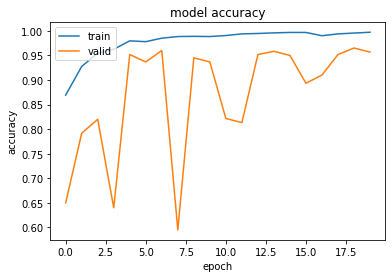

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

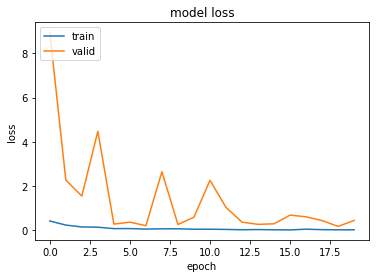

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#**15. Tester le modèle final avec une image de test**

Class Name : covid-19 --- Class Probability: 99.77%
Class Name : normal --- Class Probability: 0.23%
Class Name : viral-pneumonia --- Class Probability: 0.00%


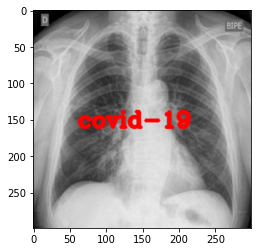

In [18]:
%matplotlib inline

classes = train_ds.class_names
image_path = "bases/medium_covid_dataset_3classes/test/covid-19/COVID-3517.png"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 1, (255,0,0), 3, cv2.LINE_AA)
        plt.imshow(img)
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

#**16. Charger et préparer les données et labels de test**

In [19]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
	dataset_test,          # chemin vers le jeu de données
	seed=42,                    # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim,input_dim),       # Taille des images d'entrée
	batch_size=nbr_batch_size,      # Taille du mini-batch
  label_mode='categorical'    # Conversion au format One-Hot
)


Found 300 files belonging to 3 classes.


#**17. Evaluation du modèle**

In [20]:
score = model.evaluate(test_ds,  steps=len(test_ds),workers = 1)
print("%s: %.2f%%" % (model.metrics_names[0], score[0]))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

19/19 [==============================] - 6s 329ms/step - loss: 1.9837 - accuracy: 0.7367
loss: 1.98%
accuracy: 73.67%


#**18. Fonction de calcul de prédiction par image**

In [21]:
def print_image_prediction(image_path, label, value):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    font = cv2.FONT_HERSHEY_COMPLEX
    textsize = cv2.getTextSize(label, font, 1, 2)[0]
    textX = (img.shape[1] - textsize[0]) / 2
    textY = (img.shape[0] + textsize[1]) / 2
    cv2.putText(img, "%s : %.2f%%" % (label, float(value) * 100), (int(textX)-250, int(textY)), font, 1, (255,0,0), 3, cv2.LINE_AA)
    plt.imshow(img)
    plt.show()

#**19. Identification des erreurs de test et génaration du fichier .csv à soumettre pour le challenge Kaggle**

In [26]:
i=0
fichier = open("results_classificationv.csv", "w")
fichier.write("Id,Predicted")
predictions_class = []
real_class = []
for class_name in test_ds.class_names:
    class_path = os.path.join(dataset_test, class_name)
    for img_name in os.listdir(class_path):
        image_path = os.path.join(class_path, img_name)
        img = Image.open(image_path).convert('RGB')
        x = tf.keras.utils.img_to_array(img,data_format='channels_last')
        x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
        x = np.expand_dims(x, axis=0)
        predictions = model.predict(x)[0]
        prediction_index = np.argmax(predictions)
        fichier.write("\n"+img_name[:]+","+classes[prediction_index])
        predictions_class.append(prediction_index)
        real_class.append(classes.index(class_name))
        if classes.index(class_name) != prediction_index:
            #print(image_path)
            #print_image_prediction(image_path, classes[prediction_index], max(predictions))
            i=i+1
print("Number of errors", i)
print("Predicitons:",predictions_class)
print("Vérité:",real_class)
fichier.close()

Number of errors 79
Predicitons: [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0]
Vérité: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
from sklearn.preprocessing import normalize
con_mat = tf.math.confusion_matrix(
    real_class, predictions_class, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)
norm_cm = normalize(con_mat, axis=1, norm='l1')
print(norm_cm)

[[0.69 0.31 0.  ]
 [0.21 0.78 0.01]
 [0.01 0.25 0.74]]


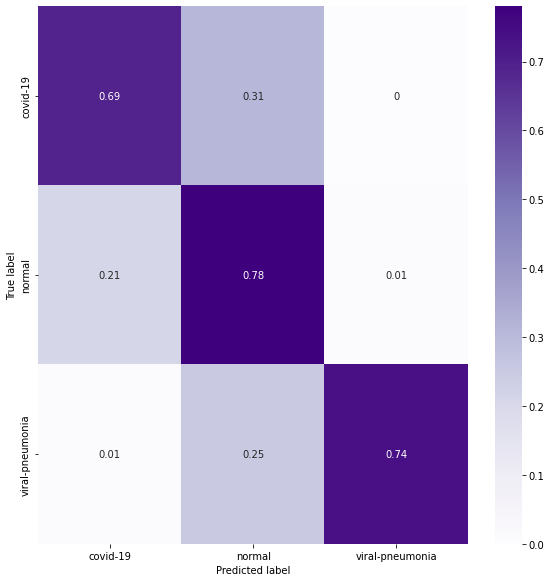

In [28]:
import seaborn as sns

figure = plt.figure(figsize=(8, 8))
sns.heatmap(norm_cm, annot=True,cmap=plt.cm.Purples,xticklabels=["covid-19","normal","viral-pneumonia"],yticklabels=["covid-19","normal","viral-pneumonia"])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()